In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

PATH = "/code/courses-uni-msc/EDA/data/german.data-numeric"

np.random.seed(42)

In [2]:
def sigmoid(eta):
    out = np.zeros_like(eta)

    pos = eta >= 0
    out[pos] = 1 / (1 + np.exp(-eta[pos]))

    neg = ~pos
    out[neg] = np.exp(eta[neg]) / (1 + np.exp(eta[neg]))

    return out


def log_likelihood(beta, X, y, eps=1e-10):
    eta = X @ beta
    p = sigmoid(eta)
    p = np.clip(p, eps, 1 - eps)
    return np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))


def loss_function(beta, X, y):
    return -log_likelihood(beta, X, y)


def gradient_loss(X, y, beta):
    eta = X @ beta
    p = sigmoid(eta)
    return X.T @ (p - y)


def hessian_loss(X, beta):
    eta = X @ beta
    p = sigmoid(eta)
    W = np.diag(p * (1 - p))
    return X.T @ W @ X

In [3]:
def newton_raphson(X, y, beta_init, tol=1e-6, max_iter=100):
    beta = beta_init.copy()
    for _ in range(max_iter):
        grad = gradient_loss(X, y, beta)
        hess = hessian_loss(X, beta)
        delta = np.linalg.solve(hess, grad)
        beta_new = beta - delta
        if np.linalg.norm(beta_new - beta) < tol:
            return beta_new
        beta = beta_new
    return beta


def gradient_descent(X, y, beta_init, lr=0.001, tol=1e-6, max_iter=1000):
    beta = beta_init.copy()
    for _ in range(max_iter):
        grad = gradient_loss(X, y, beta)
        beta_new = beta - lr * grad
        if np.linalg.norm(beta_new - beta) < tol:
            return beta_new
        beta = beta_new
    return beta


def gradient_descent_backtracking_armijo(
    X, y, beta_init, c=0.3, omega=0.8, tol=1e-6, max_iter=1000
):
    beta = beta_init.copy()
    for _ in range(max_iter):
        grad = gradient_loss(X, y, beta)
        lr = 1.0
        while True:
            beta_new = beta - lr * grad
            if loss_function(beta_new, X, y) <= loss_function(
                beta, X, y
            ) - c * lr * np.dot(grad, grad):
                break
            lr *= omega
        if np.linalg.norm(beta_new - beta) < tol:
            return beta_new
        beta = beta_new
    return beta

In [4]:
def load_german_data():
    df = pd.read_csv(PATH, sep="\s+", header=None)

    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    mean = X.mean(axis=0)
    std = X.std(axis=0)

    y = (y == 2).astype(int)

    X = (X - mean) / std
    X = np.hstack([np.ones((X.shape[0], 1)), X])

    return X, y, (mean, std)


def generate_data(n, d):
    X = np.random.randn(n, d)
    X = np.hstack([np.ones((n, 1)), X])

    beta_true = np.array([0.5, -1.0, 2.0])

    logits = X @ beta_true
    probs = sigmoid(logits)
    y = (np.random.rand(n) < probs).astype(int)

    return X, y, beta_true


def load_data(sintetic=True, n=100, d=2):
    if sintetic:
        return generate_data(n, d)
    else:
        return load_german_data()

In [5]:
def run_optimizer(optimizer, X, y, beta_init, n_steps=100):
    history = []
    time_history = []

    beta = beta_init.copy()
    start_time = time.perf_counter()

    for _ in range(n_steps):
        history.append(loss_function(beta, X, y))
        time_history.append(time.perf_counter() - start_time)
        beta = optimizer(X, y, beta)

    return beta, np.array(history), np.array(time_history)

In [6]:
X, y, data = load_data(sintetic=False)

beta_init = np.zeros(X.shape[1])

beta_nr, hist_nr, time_nr = run_optimizer(
    lambda X, y, b: newton_raphson(X, y, b, max_iter=1),
    X, y, beta_init
)

beta_gd, hist_gd, time_gd = run_optimizer(
    lambda X, y, b: gradient_descent(X, y, b, lr=0.001, max_iter=1),
    X, y, beta_init
)

beta_bt, hist_bt, time_bt = run_optimizer(
    lambda X, y, b: gradient_descent_backtracking_armijo(X, y, b, max_iter=1),
    X, y, beta_init
)

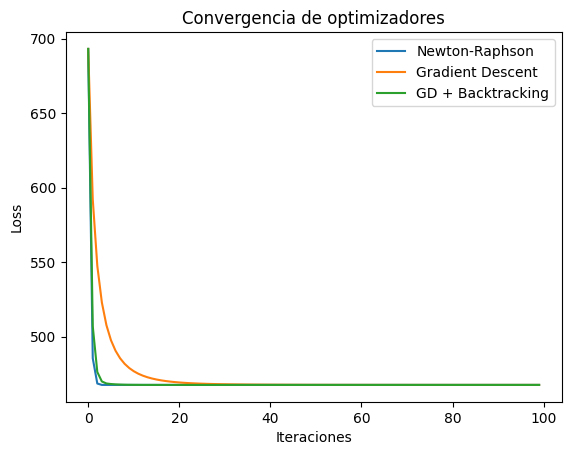

In [7]:
plt.plot(hist_nr, label="Newton-Raphson")
plt.plot(hist_gd, label="Gradient Descent")
plt.plot(hist_bt, label="GD + Backtracking")
plt.xlabel("Iteraciones")
plt.ylabel("Loss")
plt.legend()
plt.title("Convergencia de optimizadores")
plt.show()

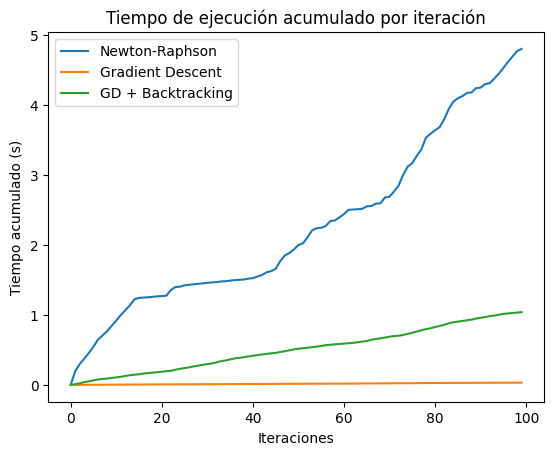

In [8]:
plt.plot(time_nr, label="Newton-Raphson")
plt.plot(time_gd, label="Gradient Descent")
plt.plot(time_bt, label="GD + Backtracking")

plt.xlabel("Iteraciones")
plt.ylabel("Tiempo acumulado (s)")
plt.title("Tiempo de ejecución acumulado por iteración")
plt.legend()
plt.show()

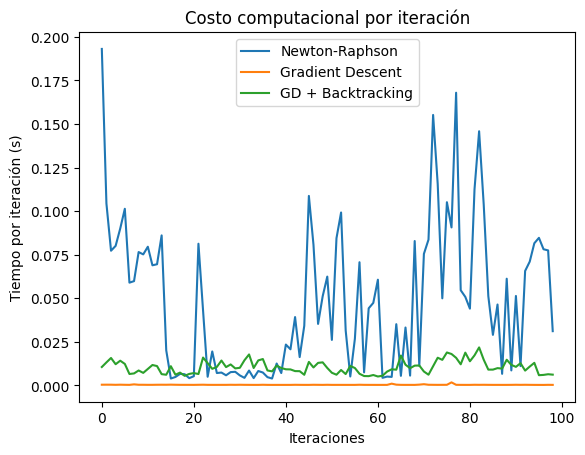

In [9]:
plt.plot(np.diff(time_nr), label="Newton-Raphson")
plt.plot(np.diff(time_gd), label="Gradient Descent")
plt.plot(np.diff(time_bt), label="GD + Backtracking")

plt.xlabel("Iteraciones")
plt.ylabel("Tiempo por iteración (s)")
plt.title("Costo computacional por iteración")
plt.legend()
plt.show()

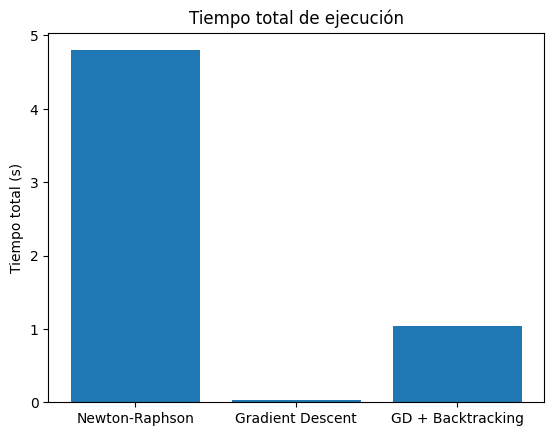

In [10]:
labels = ["Newton-Raphson", "Gradient Descent", "GD + Backtracking"]
total_times = [time_nr[-1], time_gd[-1], time_bt[-1]]

plt.bar(labels, total_times)
plt.ylabel("Tiempo total (s)")
plt.title("Tiempo total de ejecución")
plt.show()

In [11]:
def predict(x_new_raw, mean, std, beta):
    x_new_std = (x_new_raw - mean) / std
    x_new = np.hstack([1.0, x_new_std])

    eta = x_new @ beta
    p = sigmoid(eta)
    y_pred = int(p >= 0.5)

    return y_pred, eta, p

In [15]:
x_new_raw = np.array(
    [2, 48, 2, 60, 1, 3, 2, 2, 1, 22, 3, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]
)

mean, std = data

In [16]:
y_pred, eta, p = predict(x_new_raw, mean, std, beta_nr)

print("Probando la predicción con los pesos de Newton-Raphson")
print(f"Predicción para la nueva muestra: {y_pred} (probabilidad: {p:.4f})")
print("eta =", eta)
print("probabilidad =", p)

Probando la predicción con los pesos de Newton-Raphson
Predicción para la nueva muestra: 1 (probabilidad: 0.6453)
eta = 0.5983148888440523
probabilidad = 0.645270684791498


In [17]:
y_pred, eta, p = predict(x_new_raw, mean, std, beta_gd)

print("Probando la predicción con los pesos de Gradient Descent")
print(f"Predicción para la nueva muestra: {y_pred} (probabilidad: {p:.4f})")
print("eta =", eta)
print("probabilidad =", p)

Probando la predicción con los pesos de Gradient Descent
Predicción para la nueva muestra: 1 (probabilidad: 0.6452)
eta = 0.5978949735383463
probabilidad = 0.6451745618156783


In [18]:
y_pred, eta, p = predict(x_new_raw, mean, std, beta_bt)

print("Probando la predicción con los pesos de Gradient Descent + Backtracking")
print(f"Predicción para la nueva muestra: {y_pred} (probabilidad: {p:.4f})")
print("eta =", eta)
print("probabilidad =", p)

Probando la predicción con los pesos de Gradient Descent + Backtracking
Predicción para la nueva muestra: 1 (probabilidad: 0.6453)
eta = 0.5983149319646116
probabilidad = 0.6452706946616399
